# "You Snooze, You Win" Challenge

Every year, the [PhysioNet/CinC (Computing in Cardiology) Challenge](https://www.physionet.org/challenge/) invites "participants to tackle clinically interesting problems that are either unsolved or not well-solved." For this year's week 2 machine learning challenge, BWSI has revived a past PhysioNet challenge based on sleep classification.

This year's challenge focuses on the classification of nonarousal and arousal timeframes. If you would like to understand the biological implications of the challenge, we recommend reading PhysioNet's [introduction](https://physionet.org/challenge/2018/) of the challenge.

For this challenge, you will classify samples into 5 classes (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of seven physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and 'score' your model.

In [ ]:
### Import libraries ###
# from google.colab import files
import matplotlib.pyplot as plt
import matplotlib

#set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle

#data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#garbage collection (for saving RAM during training)
import gc

## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital’s Computational Clinical Neurophysiology Laboratory, and the Clinical Data Animation Laboratory.
***
**Class labels:**
- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM
***
**Class descriptions:**

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/sleepStagesTable.svg?raw=true">

***
**Physiological signal description:**

O2-M1 - posterior brain activity (electroencephalography)

E1-M2 - left eye activity (electrooculography)

Chin1-Chin2 - chin movement (electromyography)

ABD - abdominal movement (electromyography)

CHEST - chest movement (electromyography)

AIRFLOW - respiratory airflow

ECG - cardiac activity (electrocardiography)
***
Run both cell blocks to get the challenge data.

In [ ]:
# Clone repo and move into data directory (only run this once)
if not os.path.exists("./Data_Public/ChallengeProjects/Week2/"):
    os.system("git clone https://github.com/BeaverWorksMedlytics2020/Data_Public")
os.chdir("./Data_Public/ChallengeProjects/Week2/")


## Loading Data in Memory
Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: np array shape (4000, 12000, 7). Contains 4000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **labels_train**: np array shape (4000,). Contains ground truth labels for data_train. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4000 unique IDs. The order of the IDs corresponds to the order of the training data.
* **data_test**: np array shape (1000, 12000, 7). Contains 1000 samples (60s each) of 12000 data points (200Hz x 60s), for 7 different signals.
* **ID_test**: list of 1000 unique IDs. The order of the IDs corresponds to the order of the training data.

We encourage you to print each of these variables to see what they look like.

In [ ]:
### Run once to import data ###

def get_file_locs():
    '''
    find all files in 'training' and 'test' directories and put their names
    under 'training' and 'test' keys in the file_dict dictionary
    '''

    file_dict = {'training':[], 'test':[]}
    for data_type in file_dict:
        for file in os.listdir('./' + data_type):
            file_dict[data_type].append(data_type + '/' + file)

    return file_dict

def get_sample_data(data_type, id_number):
    '''
    get signal data, label, and filename associated with given data type and index num

    parameters:

     data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

     id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)

    returns:

     sample_data -- dataframe with 1 row and 2 columns-- column "Signal" contains a series object
                    and column "Label" contains numeric label for that sample
    '''
    file = './' + data_type + '/' + str(id_number) + '.xz'

    #sample_data is a dataframe with 1 row and 2 columns--
    #"Signal" (contains a series object) and "Label" (contains numeric label)
    sample_data = pd.read_pickle('./' + file)

    return sample_data, file.split('/')[2]

file_dict = get_file_locs()
print(f"{len(file_dict['training'])} training samples found, {len(file_dict['test'])} test samples found")

data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
  sample_data, ID = get_sample_data('training', i)
  data_train[i] = np.array(list(sample_data['Signal']), dtype=float).reshape(12000, 7)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
  ID_train.append(ID)
  if(i%500==0):
    print('Loading training sample ' + str(i))

data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
  sample_data, ID = get_sample_data('test', i)
  data_test[i] = np.array(list(sample_data['Signal']), dtype=float).reshape(12000, 7)
  ID_test.append(ID)
  if(i%500==0):
    print('Loading test sample ' + str(i))

4000 training samples found, 1000 test samples found
Loading training sample 0


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 500


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 1000


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 1500


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 2000


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 2500


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 3000


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading training sample 3500


/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipython-input-4-2173094696.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels_train[i] = np.array(list(sample_data['Label']), dtype=float)
/tmp/ipyth

Loading test sample 0
Loading test sample 500


## Processing labels

In [ ]:
### Create label array for all training samples using categorical datatype ###
train_labels = np.ndarray(shape = (1, 4000))

#set labels to integers first
for i in range(4000):
    train_labels[0][i] = i//800 # This is a way to label each entry (since classes are in order)


## Shuffle and Partition

In [ ]:
### Shuffle and partition all train data

#(Training data is ordered by default so shuffling before partitioning is important)

#--Shuffle data_train--
#(Note that data is only shuffled in first dimension, which is what we want)
shuffled_idx = np.random.permutation(len(data_train))
data_train = data_train[shuffled_idx]
train_labels = train_labels.squeeze(axis=0)
train_labels = train_labels[shuffled_idx]
#--Scale all labeled data in data_train--

#initialize standard scaler
scaler = StandardScaler()

#Standard scaler is meant for 2D arrays, so we reshape, scale, and then reshape again
reshaped_X_train = data_train.reshape((data_train.shape[0]*data_train.shape[1], data_train.shape[2])).copy()
reshaped_X_train = scaler.fit_transform(reshaped_X_train)
data_train = reshaped_X_train.reshape((data_train.shape[0], data_train.shape[1], data_train.shape[2]))

del reshaped_X_train #get rid of large temporary variable

#--Scale unlabeled test data--
#Because we scaled labeled data before training, we need to also scale test data --

#Standard scaler is meant for 2D arrays, so we reshape, apply scaling, and then
#reshape again to get back to original
reshaped_X_test = data_test.reshape((data_test.shape[0]*data_test.shape[1], data_test.shape[2])).copy()
reshaped_X_test = scaler.transform(reshaped_X_test)
data_test = reshaped_X_test.reshape((data_test.shape[0], data_test.shape[1], data_test.shape[2]))

del reshaped_X_test #get rid of large temporary variable

# need to reshape to (n, c, l)
data_train = data_train.transpose((0,2,1))
data_test = data_test.transpose((0,2,1))

In [ ]:
#--create 3 partitions of provided training data--
# Note we are breaking up provided labeled data into training, validation, and "mock test" sets

val_size = 1000
mocktest_size = 500

X_test = data_train[0:mocktest_size, :, :]
y_test = train_labels[0:mocktest_size]

X_val = data_train[mocktest_size:mocktest_size+val_size, :, :]
y_val = train_labels[mocktest_size:mocktest_size+val_size]

X_tr = data_train[mocktest_size+val_size:,:,:]
y_tr = train_labels[mocktest_size+val_size:]

del data_train
del train_labels

### Implement your model here

Feel free to use whatever architecture you want so long as it incorporates convolutions.

In [ ]:
# TODO: replace me with something else
#       just an example, feel free to go crazy

import torch.nn as nn
model1 = nn.Sequential(
    nn.MaxPool1d(2),  # [7, 12000] → [7, 6000]

    nn.Conv1d(7, 16, kernel_size=7, padding=3),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Conv1d(16, 32, kernel_size=5, padding=2),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.MaxPool1d(2),  # → [32, 3000]

    nn.Conv1d(32, 64, kernel_size=5, padding=2),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(4),  # → [64, 750]

    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(64, 5)
)

In [ ]:

model2 = nn.Sequential(
    nn.MaxPool1d(4),  # [7, 12000] → [7, 3000]

    nn.Conv1d(7, 16, kernel_size=3, padding=1),
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Conv1d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.MaxPool1d(4),  # → [32, 750]

    nn.Conv1d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(5),  # → [64, 150]

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(64, 5)
)

In [ ]:
import torch.nn as nn

model3 = nn.Sequential(
    nn.MaxPool1d(2),  # [7, 12000] -> [7, 6000]

    nn.Conv1d(7, 32, kernel_size=5, padding=2),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.MaxPool1d(2),  # 6000 -> 3000

    nn.Conv1d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.MaxPool1d(3),  # 3000 -> 1000

    nn.Conv1d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Conv1d(128, 128, kernel_size=3, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.MaxPool1d(5),  # 1000 -> 200

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(128, 5)
)


In [ ]:
model4 = nn.Sequential(
    nn.MaxPool1d(4),  # [7, 12000] → [7, 3000]

    nn.Conv1d(7, 16, kernel_size=7, padding=3),  # padding = kernel//2
    nn.BatchNorm1d(16),
    nn.ReLU(),

    nn.Conv1d(16, 32, kernel_size=5, padding=2),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.MaxPool1d(4),  # → [32, 750]

    nn.Conv1d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Conv1d(64, 64, kernel_size=3, padding=1),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(5),  # → [64, 150]

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(64, 5)
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

epochs = 200
batch_size = 600
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [model1]
for model in models:
    model.to(device)

criterions = [nn.CrossEntropyLoss() for _ in models]
optimizers = [optim.Adam(model.parameters(), lr=lr) for model in models]

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_tr, dtype=torch.float32),
    torch.tensor(y_tr, dtype=torch.long)
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

x_plot = []
y_plot = []
# --- Training Loop ---
for epoch in range(epochs):
    for model in models:
        model.train()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        for model, optimizer, criterion in zip(models, optimizers, criterions):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # ensembling stuff
    val_accuracies = []
    for model in models:
        model.eval()
        with torch.no_grad():
            vout = model(X_val_tensor)
            preds = torch.argmax(vout, dim=1)
            acc = (preds == y_val_tensor).float().mean().item()
            val_accuracies.append(acc)

    acc_sum = sum(val_accuracies)
    weights = [acc / acc_sum for acc in val_accuracies]


    with torch.no_grad():
        ensemble_outputs = torch.zeros((X_val_tensor.size(0), 5), device=device)
        val_loss = 0
        criterion = nn.CrossEntropyLoss()

        for model, weight in zip(models, weights):
            out = model(X_val_tensor)
            probs = torch.softmax(out, dim=1)
            ensemble_outputs += weight * probs
            val_loss += criterion(out, y_val_tensor).item()

        preds = torch.argmax(ensemble_outputs, dim=1)
        val_loss /= len(models)
        val_acc = (preds == y_val_tensor).float().mean().item()

    print(('Epoch #%d\tValidation Loss: %.4f\tValidation Accuracy: %.4f') %
        (epoch + 1, val_loss, val_acc))
    x_plot.append(epoch)
    y_plot.append(val_acc)


Epoch #1	Validation Loss: 0.8865	Validation Accuracy: 0.6660
Epoch #2	Validation Loss: 0.8838	Validation Accuracy: 0.6680
Epoch #3	Validation Loss: 0.8771	Validation Accuracy: 0.6680
Epoch #4	Validation Loss: 0.8589	Validation Accuracy: 0.6760
Epoch #5	Validation Loss: 0.8492	Validation Accuracy: 0.6840
Epoch #6	Validation Loss: 0.8553	Validation Accuracy: 0.6750
Epoch #7	Validation Loss: 0.8551	Validation Accuracy: 0.6780
Epoch #8	Validation Loss: 0.8533	Validation Accuracy: 0.6820
Epoch #9	Validation Loss: 0.8535	Validation Accuracy: 0.6840
Epoch #10	Validation Loss: 0.8550	Validation Accuracy: 0.6860
Epoch #11	Validation Loss: 0.8639	Validation Accuracy: 0.6740
Epoch #12	Validation Loss: 0.8728	Validation Accuracy: 0.6730
Epoch #13	Validation Loss: 0.8669	Validation Accuracy: 0.6780
Epoch #14	Validation Loss: 0.8651	Validation Accuracy: 0.6780
Epoch #15	Validation Loss: 0.8644	Validation Accuracy: 0.6810
Epoch #16	Validation Loss: 0.8661	Validation Accuracy: 0.6840
Epoch #17	Validat

In [ ]:
for epoch in range(epochs):
    for model in models:
        model.train()

    running_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        for model, optimizer, criterion in zip(models, optimizers, criterions):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # accumulate metrics
            running_loss += loss.item() * inputs.size(0)  # sum loss over batch
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ensembling stuff (your existing validation evaluation)
    val_accuracies = []
    for model in models:
        model.eval()
        with torch.no_grad():
            vout = model(X_val_tensor)
            preds = torch.argmax(vout, dim=1)
            acc = (preds == y_val_tensor).float().mean().item()
            val_accuracies.append(acc)

    acc_sum = sum(val_accuracies)
    weights = [acc / acc_sum for acc in val_accuracies]

    with torch.no_grad():
        ensemble_outputs = torch.zeros((X_val_tensor.size(0), 5), device=device)
        val_loss = 0
        criterion = nn.CrossEntropyLoss()

        for model, weight in zip(models, weights):
            out = model(X_val_tensor)
            probs = torch.softmax(out, dim=1)
            ensemble_outputs += weight * probs
            val_loss += criterion(out, y_val_tensor).item()

        preds = torch.argmax(ensemble_outputs, dim=1)
        val_loss /= len(models)
        val_acc = (preds == y_val_tensor).float().mean().item()

    # 📋 Print both training and validation metrics
    print(('Epoch #%d\tTrain Loss: %.4f\tTrain Acc: %.4f\tVal Loss: %.4f\tVal Acc: %.4f') %
        (epoch + 1, train_loss, train_acc, val_loss, val_acc))

    x_plot.append(epoch)
    y_plot.append(val_acc)


Epoch #1	Train Loss: 0.8073	Train Acc: 0.6744	Val Loss: 1.4837	Val Acc: 0.4650
Epoch #2	Train Loss: 0.8244	Train Acc: 0.6748	Val Loss: 0.9501	Val Acc: 0.6320
Epoch #3	Train Loss: 0.8220	Train Acc: 0.6804	Val Loss: 0.9047	Val Acc: 0.6320
Epoch #4	Train Loss: 0.7944	Train Acc: 0.6916	Val Loss: 0.9052	Val Acc: 0.6060
Epoch #5	Train Loss: 0.8005	Train Acc: 0.6820	Val Loss: 0.8987	Val Acc: 0.6130
Epoch #6	Train Loss: 0.7907	Train Acc: 0.6876	Val Loss: 0.8582	Val Acc: 0.6460
Epoch #7	Train Loss: 0.7884	Train Acc: 0.6920	Val Loss: 0.8893	Val Acc: 0.6510
Epoch #8	Train Loss: 0.8032	Train Acc: 0.6812	Val Loss: 1.0569	Val Acc: 0.5780
Epoch #9	Train Loss: 0.7837	Train Acc: 0.6856	Val Loss: 1.0882	Val Acc: 0.5740
Epoch #10	Train Loss: 0.7985	Train Acc: 0.6776	Val Loss: 0.9012	Val Acc: 0.6470
Epoch #11	Train Loss: 0.7960	Train Acc: 0.6840	Val Loss: 0.9158	Val Acc: 0.6470
Epoch #12	Train Loss: 0.8138	Train Acc: 0.6684	Val Loss: 0.9279	Val Acc: 0.6320
Epoch #13	Train Loss: 0.8274	Train Acc: 0.6756	Va

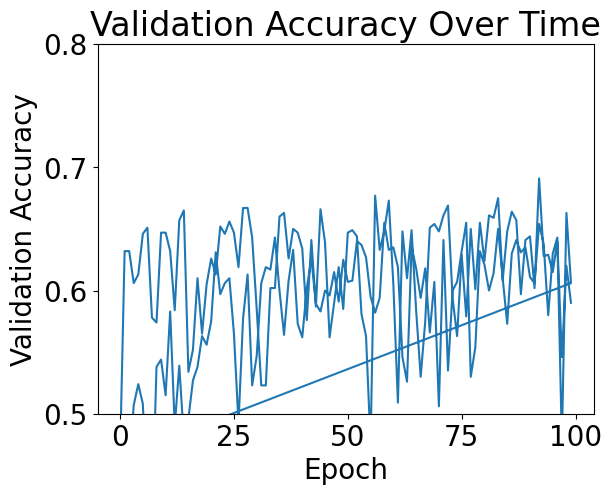

In [ ]:
plt.plot(x_plot, y_plot)
plt.ylim(0.5, 0.8)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Over Time')
plt.show()

Epoch #1	Train Loss: 0.5174	Train Acc: 0.8008	Val Loss: 0.9590	Val Acc: 0.6760
Epoch #2	Train Loss: 0.5362	Train Acc: 0.7908	Val Loss: 0.9786	Val Acc: 0.6690
Epoch #3	Train Loss: 0.5251	Train Acc: 0.7988	Val Loss: 1.0025	Val Acc: 0.6610
Epoch #4	Train Loss: 0.5285	Train Acc: 0.7912	Val Loss: 1.0170	Val Acc: 0.6600
Epoch #5	Train Loss: 0.5347	Train Acc: 0.7908	Val Loss: 0.9600	Val Acc: 0.6760
Epoch #6	Train Loss: 0.5325	Train Acc: 0.7996	Val Loss: 0.9505	Val Acc: 0.6720
Epoch #7	Train Loss: 0.5143	Train Acc: 0.8068	Val Loss: 0.9443	Val Acc: 0.6700
Epoch #8	Train Loss: 0.5068	Train Acc: 0.8032	Val Loss: 0.9527	Val Acc: 0.6820
Epoch #9	Train Loss: 0.5261	Train Acc: 0.7956	Val Loss: 0.9444	Val Acc: 0.6750
Epoch #10	Train Loss: 0.5165	Train Acc: 0.8120	Val Loss: 0.9558	Val Acc: 0.6720
Epoch #11	Train Loss: 0.5201	Train Acc: 0.7988	Val Loss: 0.9727	Val Acc: 0.6690
Epoch #12	Train Loss: 0.5230	Train Acc: 0.7988	Val Loss: 0.9719	Val Acc: 0.6670
Epoch #13	Train Loss: 0.5212	Train Acc: 0.7964	Va

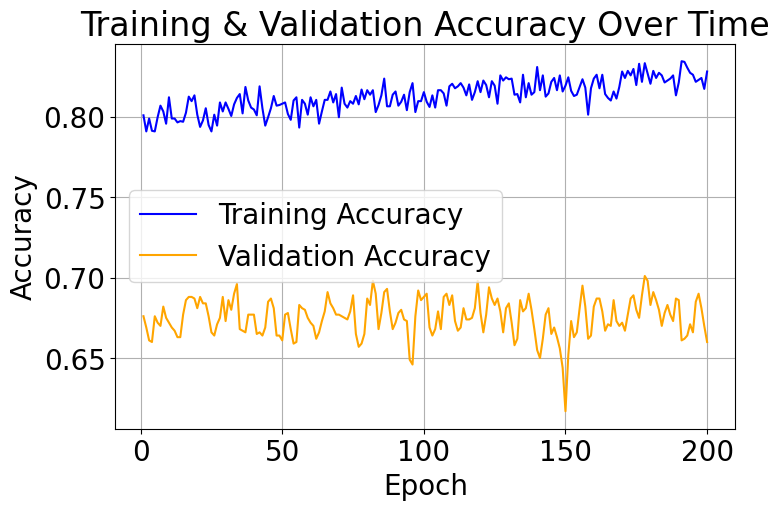

In [ ]:
import matplotlib.pyplot as plt

# initialize lists
x_plot = []
y_plot = []            # validation accuracy
train_acc_plot = []    # training accuracy

for epoch in range(epochs):
    for model in models:
        model.train()

    running_loss = 0
    correct = 0
    total = 0

    # ----- TRAIN -----
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        for model, optimizer, criterion in zip(models, optimizers, criterions):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # ----- VALIDATION -----
    val_accuracies = []
    for model in models:
        model.eval()
        with torch.no_grad():
            vout = model(X_val_tensor)
            preds = torch.argmax(vout, dim=1)
            acc = (preds == y_val_tensor).float().mean().item()
            val_accuracies.append(acc)

    acc_sum = sum(val_accuracies)
    weights = [acc / acc_sum for acc in val_accuracies]

    with torch.no_grad():
        ensemble_outputs = torch.zeros((X_val_tensor.size(0), 5), device=device)
        val_loss = 0
        criterion = nn.CrossEntropyLoss()

        for model, weight in zip(models, weights):
            out = model(X_val_tensor)
            probs = torch.softmax(out, dim=1)
            ensemble_outputs += weight * probs
            val_loss += criterion(out, y_val_tensor).item()

        preds = torch.argmax(ensemble_outputs, dim=1)
        val_loss /= len(models)
        val_acc = (preds == y_val_tensor).float().mean().item()

    print(('Epoch #%d\tTrain Loss: %.4f\tTrain Acc: %.4f\tVal Loss: %.4f\tVal Acc: %.4f') %
          (epoch + 1, train_loss, train_acc, val_loss, val_acc))

    x_plot.append(epoch+1)
    y_plot.append(val_acc)
    train_acc_plot.append(train_acc)

# ----- PLOT BOTH -----
plt.figure(figsize=(8, 5))
plt.plot(x_plot, train_acc_plot, label='Training Accuracy', color='blue')
plt.plot(x_plot, y_plot, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()


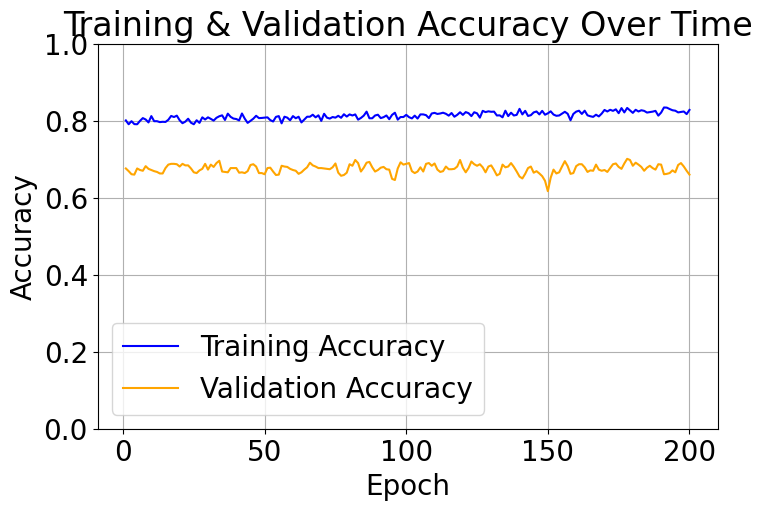

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(x_plot, train_acc_plot, label='Training Accuracy', color='blue')
plt.plot(x_plot, y_plot, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Training & Validation Accuracy Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
### Run once after you have finished training your model ###
#Reminder: Please ensure order of test data points has not been changed.

#-- Evaluate model for test data --
model.eval()
test_output = model(torch.tensor(data_test, dtype=torch.float32))
test_pred = torch.argmax(test_output, dim=1).detach().numpy()

file_path = '../../../test_pred.pickle'

import pickle
with open(file_path, 'wb') as f:
    pickle.dump(test_pred, f)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## Submitting Your Model

After training your classifier, run it on the test data to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a pandas dataframe with 5 columns (classes) and 1000 rows (samples). Note that your predictions must follow the original test sample order (0.xz, 1.xz, 2.xz, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your pandas dataframe with the file number for each sample; 2) sort the dataframe using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions dataframe should be exported as an .xz file using dataframe.to_pickle() followed by files.download().

Example code of the prediction format and export is presented in the cell block below.

Your model will be evaluated on Area Under the ROC Curve (ROCAUC), Matthews Correlation Coefficient (MCC) and creativity.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

- **Area Under the ROC Curve (AUCROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." Below is the multi-class ROC curve for the example classifier. The AUCROC score should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

<img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/blob/master/Images/Week2/MultiClassRocCurve_exampleClassifier.png?raw=true" width="600" height="500">

- **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

 ![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

Using these metrics, the example classifier has the following scores on test data:
- AUCROC: 0.727
- MCC: 0.163
- Creativity: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUCROC and MCC metrics when evaluating your classifier.

In [ ]:
model.eval()
test_pred = pd.DataFrame(model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy())
test_predict = test_pred.idxmax(axis=1)
test_labels = y_test.astype(int)
test_labels_one_hot = pd.DataFrame(np.eye(5)[test_labels])

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

""" Initalize key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

In [ ]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [ ]:
print(roc_auc_agg, mcc)